# The Battle of Neighborhoods: Opening a new Gym

## Introduction/Business Problem

### Introduction

Opening a gym can be a profitable business or a money sinkhole, it's for reason important to identify the best location to start a new gym.

In this notebook, we will look at how to find a good place for a gym in New York

### Business Problem

The first step is to identify the requirements for the best location, for this step we have identified an interesting article on the location requirements for identifying the best location for a new gym. 
The [Article](https://www.theptdc.com/how-to-open-a-gym) is written and published by a renowned source of articles about business development for fitness. [The Personal Trainer Development Center](https://www.theptdc.com/about) or PTDC is a premier source of free information for smart and passionate fitness professionals. 

The PTDC archive contains more than 1,000 articles on the practice and business of fitness, written by hundreds of experts from all corners of the globe.

The article identifies 10 main attributes for a new location:

1. _High Ceilings & Natural Light_ 
2. _Relatively New” Construction_
3. _Clean Sight Lines_
4. _Ample Waiting Space for Parents_
5. _Sufficient Parking_
6. _Community Restrooms_
7. _Building Property Manager_
8. _Availability of Signage_
9. _**Minimal local competition**_
10. _**Appropriate Adjacent Tenants**_

While point 1 to 8 focus on a single lot the last two steps requires an analysis of the neighbourhood. Specifically, we want to find a neighbourhood that is very good for opening a gym, but where there is no or little gym. 

This seems a contradiction, can Data Science help with this step?

### Data Science Question

We will proceed to identify which is the Neighbours with the maximum number of gyms. (MaxGymNeigh)

Parallelly we will proceed in clustering the various Neighbourd based on their feature: Population, Income, and type of business excluding Gym.

In cluster containing MaxGymNeigh, we will find Neighbours that are similar (and for this reason good business opportunities) and locate the most similar with the minimal number of gym

## Data

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

### Overview

#### Plotting data
We want to have a plotting that is nicer than simple marker on a map, for this reason, we need the geojson file of the geometries of the various New York City zip codes.
Fortunately, also these data are available [online](https://raw.githubusercontent.com/fedhere/PUI2015_EC/master/mam1612_EC/nyc-zip-code-tabulation-areas-polygons.geojson)
#### Census
The Census data are also available [online](http://zipatlas.com/us/ny/zip-code-comparison/population-density.htm)
#### Income
The income data are provided by IRS divided by zip code and available [online](https://www.irs.gov/pub/irs-soi/17zp33ny.xlsx) the fields and the data are described on the [help document](https://www.irs.gov/pub/irs-soi/17zpdoc.docx)
#### Businesses data
For the statitics and the information about the various venues in a given Neighbourd we will use the FourSquare API

### Exploration

#### Plotting data
We want to have a plotting that is nicer than simple marker on a map, for this reason, we need the geojson file of the geometries of the various New York City zip codes.
Fortunately, also these data are available [online](https://raw.githubusercontent.com/fedhere/PUI2015_EC/master/mam1612_EC/nyc-zip-code-tabulation-areas-polygons.geojson)

We want to have a greater control on the geographic data compared to what is presented in this course, for this reason we will use [geopandas](https://geopandas.org/) to manipulate the geographic data.

GeoPandas is an open source project to make working with geospatial
data in python easier.  GeoPandas extends the datatypes used by
[pandas](http://pandas.pydata.org) to allow spatial operations on geometric types.  Geometric
operations are performed by [shapely](https://shapely.readthedocs.io).  Geopandas further depends on
[fiona](https://fiona.readthedocs.io) for file access and [descartes](https://pypi.python.org/pypi/descartes) and [matplotlib](http://matplotlib.org) for plotting.

Let's load the data and do some preliminary cleanup

In [2]:
import geopandas as gpd
import folium
nyc_geozip_file = 'nyc-zip-code.geojson'
nyc_geozip = gpd.read_file(nyc_geozip_file)
nyc_geozip=nyc_geozip[['postalCode','PO_NAME','borough','Shape_Area','@id','geometry']]
nyc_geozip.columns=['ZipCode','ZipCodeName','Borough','Area','@id','geometry']
nyc_geozip['City']='New York'
nyc_geozip=nyc_geozip.astype({'ZipCode': 'int32'})
nyc_geozip['Borough']=pd.Categorical(nyc_geozip['Borough'])
nyc_geozip['BoroughId'] = nyc_geozip['Borough'].cat.codes
nyc_geozip.head()

,ZipCode,ZipCodeName,Borough,Area,@id,geometry,City,BoroughId
0,11372,Jackson Heights,Queens,2.016328e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.86942 40.74916, -73.89507 40.746...",New York,3
1,11004,Glen Oaks,Queens,2.260653e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.71068 40.75004, -73.70869 40.748...",New York,3
2,11040,New Hyde Park,Queens,6.269333e+06,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.70098 40.73890, -73.70309 40.744...",New York,3
3,11426,Bellerose,Queens,4.941836e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.72270 40.75373, -73.72251 40.753...",New York,3
4,11365,Fresh Meadows,Queens,6.938587e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.81089 40.72717, -73.81116 40.728...",New York,3


Let's combine all the geomtries and calculate the center of the resulting poligon

In [3]:
nyc_centroid=nyc_geozip[['geometry','City']].dissolve(by='City').centroid
nyc_centroid

City
New York    POINT (-73.93113 40.69480)
dtype: geometry

In the geojson list some Zip Codes are duplicated with different geometry, we need to geometrically merge the lines with the same ZipCode

In [4]:
nyc_geozip=nyc_geozip.dissolve(by='ZipCode')
nyc_geozip.reset_index(inplace=True)

It's easier to work with folium and geojson if it's store on a file

We add also Latitude and longitude colums

In [5]:
nyc_geozip['Latitude']=nyc_geozip.centroid.y
nyc_geozip['Longitude']=nyc_geozip.centroid.x
nyc_geozip.head()

,ZipCode,geometry,ZipCodeName,Borough,Area,@id,City,BoroughId,Latitude,Longitude
0,83,"POLYGON ((-73.94922 40.79691, -73.97301 40.764...",Central Park,Manhattan,3.830099e+07,http://nyc.pediacities.com/Resource/PostalCode...,New York,2,40.782451,-73.965580
1,10001,"POLYGON ((-74.00827 40.75259, -74.00763 40.754...",New York,Manhattan,1.779494e+07,http://nyc.pediacities.com/Resource/PostalCode...,New York,2,40.750215,-73.996937
2,10002,"POLYGON ((-73.97442 40.73642, -73.97450 40.735...",New York,Manhattan,2.628013e+07,http://nyc.pediacities.com/Resource/PostalCode...,New York,2,40.716166,-73.985712
3,10003,"POLYGON ((-73.97986 40.73497, -73.98864 40.722...",New York,Manhattan,1.553838e+07,http://nyc.pediacities.com/Resource/PostalCode...,New York,2,40.731929,-73.988841
4,10004,"MULTIPOLYGON (((-74.02418 40.68392, -74.02530 ...",New York,Manhattan,4.001782e+06,http://nyc.pediacities.com/Resource/PostalCode...,New York,2,40.694086,-74.020417


In [6]:
nyc_geozip[['ZipCode','@id','geometry','Latitude','Longitude']].to_file("nyc_clean.geojson", driver='GeoJSON')

We can now use all the data to plot the ZipCodes are using the BoroughId as Category

In [7]:
import folium
m = folium.Map(location=[nyc_centroid.y,nyc_centroid.x],zoom_start =10)

nyc_geozip.set_index('ZipCode',inplace=True)

    
def style_function(feature):
    zipcode = feature['properties']['ZipCode']
   
    id= int(nyc_geozip.loc[zipcode,'BoroughId'])
    
    if id == 0:
        color = 'green'
    elif id == 1:
        color = 'blue'
    elif id == 2:
        color = 'red'
    elif id == 3:
        color = 'black'        
    elif id == 4:
        color = 'purple'    
    
    return {
        'fillOpacity': 0.6,
        'fillColor': color,
        'color':color,
        'weight':1
    }

folium.GeoJson(
    data = 'nyc_clean.geojson',
    style_function=style_function
).add_to(m)

m

#### Census
The Census data are also available [online](http://zipatlas.com/us/ny/zip-code-comparison/population-density.htm)

The data is distributed on 16 indipendente pages from http://zipatlas.com/us/ny/zip-code-comparison/population-density.htm
to http://zipatlas.com/us/ny/zip-code-comparison/population-density.16.htm and contains also the geographic center of each zip code. For the parsing we will use BeatifulSoup

In [8]:
census_url_bases = ['']+[str(x)+'.' for x in np.arange(2,17)]
census_urls = ['http://zipatlas.com/us/ny/zip-code-comparison/population-density.%shtm' % x for x in census_url_bases]


This function will produce a data frame for each page

In [9]:
def load_into_census(target_url):
    target_frame = pd.DataFrame()
    page = requests.get(target_url)
    soup = BeautifulSoup(page.content, 'html.parser')
    data_table=soup.find_all("table", frame="box")[0]
    rows=data_table.find_all("tr")[1:]
    for row in rows:
        (idx,zipcode,latlng,name,pop,dens,pos)=[x.get_text() for x in row.find_all("td")]
        (latitude,longitude) = [float(x.strip()) for x in latlng.split(',')]
        target_frame=target_frame.append([[int(zipcode),latitude,longitude,int(pop.replace(',',''))]])
    return target_frame

Here we load the data merge the dataframes into a single dataframe

In [10]:
census = pd.DataFrame()
for census_url in census_urls:
    tf = load_into_census(census_url)
    census = census.append(tf)

Settings the columns and making some housekeeping

In [11]:
census.columns = ['ZipCode','Latitude','Longitude','Population']
census.reset_index(inplace=True)
census.drop('index',axis=1,inplace=True)
census.head()


,ZipCode,Latitude,Longitude,Population
0,10162,40.769298,-73.949942,1726
1,10028,40.776865,-73.954721,44987
2,10128,40.781656,-73.950281,59856
3,10031,40.825857,-73.949451,60221
4,10009,40.726622,-73.978955,58595


Let's put the populatation data on a map

In [12]:
import folium
m = folium.Map(location=[nyc_centroid.y,nyc_centroid.x],zoom_start =10)
nyc_geozip_tmp = nyc_geozip.reset_index(inplace=False)

c=folium.Choropleth(
    geo_data='nyc_clean.geojson',
    data=census,
     columns=['ZipCode', 'Population'],
    key_on='feature.properties.ZipCode',
    fill_color='YlGn',
    name='choropleth',
    highlight=True
).add_to(m)

m

Some zipcode have **no population data**: this is partially expected because they refers to special location let see to which are they refers, but there area also are where the data is missing, we will integrate them with the IRS information

#### Income

For the Income for Zip Code we will use the data provided by IRS available [online](https://www.irs.gov/pub/irs-soi/17zp33ny.xlsx) the fields and the data are described on the [help document](https://www.irs.gov/pub/irs-soi/17zpdoc.docx)

The Excel file structure is human oriented and for this reason quite a lot data wrangling will be required.
![IRS Excel image](irs.jpeg "Logo Title Text 1")

First we load the data skipping the header and footer, column names will be added later

In [13]:
import pandas as pd
irs_raw = pd.read_excel('irs.xlsx',skiprows=15,header=None,thousands='P',skipfooter=18)
irs_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,10001.0,"$1 under $25,000",3640.0,2810.0,330.0,410.0,3260.0,170.0,2100.0,1830.0,...,0.0,0.0,700.0,763.0,2490.0,4538.0,2420.0,4278.0,90.0,231.0
1,10001.0,"$25,000 under $50,000",2540.0,1900.0,240.0,340.0,2320.0,130.0,1420.0,1590.0,...,0.0,0.0,510.0,1319.0,2010.0,5134.0,1960.0,4953.0,70.0,182.0
2,10001.0,"$50,000 under $75,000",2020.0,1600.0,190.0,170.0,1850.0,90.0,1080.0,1240.0,...,0.0,0.0,460.0,1710.0,1550.0,4354.0,1490.0,4036.0,80.0,318.0
3,10001.0,"$75,000 under $100,000",1480.0,1180.0,180.0,80.0,1370.0,50.0,850.0,880.0,...,0.0,0.0,360.0,1500.0,1110.0,3879.0,1060.0,3423.0,80.0,456.0
4,10001.0,"$100,000 under $200,000",2920.0,2160.0,580.0,90.0,2730.0,100.0,1730.0,1850.0,...,50.0,15.0,610.0,4016.0,2290.0,11180.0,2140.0,9630.0,190.0,1549.0


We are interested only in the columns with zip code, Income Range (will be used later) and income, looking in the documentation we can see that we want only column 0, 1 and 20.

The NaN values are due to empty lines and/or lines with total (for which the Income Range is not defined) for this reason we drop the ros

In [14]:
irs=irs_raw[[0,1,20]].copy()
irs.columns = ['ZipCode','IncomeRange','TotalIncome (x1000)']
irs.dropna(subset = ["ZipCode","IncomeRange","TotalIncome (x1000)"], inplace=True)
irs.drop('IncomeRange',axis=1,inplace=True)
irs.head()


,ZipCode,TotalIncome (x1000)
0,10001.0,44319.0
1,10001.0,96947.0
2,10001.0,127601.0
3,10001.0,129884.0
4,10001.0,417092.0


At this step the IncomeRange is not needed anymore: we drop the column and calculate the total declared income for zipcode

In [15]:
irs=irs.groupby('ZipCode').sum().reset_index()
irs['ZipCode']=irs['ZipCode'].astype('int32')
irs.head()

,ZipCode,TotalIncome (x1000)
0,10001,2820411.0
1,10002,2523419.0
2,10003,8866747.0
3,10004,943900.0
4,10005,2315913.0


The IRS data refers also to ZipCode outside the city boundary, we take inconsideration only zip in the geographic data we have loaded

In [16]:
nyc_geozip_tmp = nyc_geozip.reset_index()
v = nyc_geozip_tmp['ZipCode'].values
irs=irs.loc[irs['ZipCode'].isin(v)]
irs.head()

,ZipCode,TotalIncome (x1000)
0,10001,2820411.0
1,10002,2523419.0
2,10003,8866747.0
3,10004,943900.0
4,10005,2315913.0


In [17]:
import folium
m = folium.Map(location=[nyc_centroid.y,nyc_centroid.x],zoom_start =10)
nyc_geozip_tmp = nyc_geozip.reset_index(inplace=False)
c=folium.Choropleth(
    geo_data='nyc_clean.geojson',
    data=irs,
     columns=['ZipCode', 'TotalIncome (x1000)'],
    key_on='feature.properties.ZipCode',
    fill_color='YlGn',
    name='choropleth',
    highlight=True
).add_to(m)

m

We can see that also in the IRS data some ZipCode are not present: this area are all special cases (park, airport) that we can easily ignore.

Before integrating with the Census data we need to take care of the missing data in the census we have identified.
Let's see for which ZipCode we have the IRS data but not the census data

In [18]:
v = census['ZipCode'].values
missing=irs.loc[~irs['ZipCode'].isin(v)][['ZipCode']].copy()
missing

,ZipCode
38,10065
40,10075
225,11109


We can see how for three zipcodes we have IRS data, but not census data, we need to integrate this data with and additional source

In [19]:
def get_population(zipcode):
    url_additional_census = 'https://www.zip-codes.com/zip-code/%s/zip-code-%s.asp' % (zipcode,zipcode)
    page = requests.get(url_additional_census)
    soup = BeautifulSoup(page.content, 'html.parser')
    census_table=soup.find_all('table', {"class": "statTable"})[1]
    population = int(census_table.find('tr').find('td',{"class": "info"}).get_text().replace(',',''))
    return population
missing['Latitude']=0
missing['Longitude']=0
missing['Population']=0
for index, row  in missing.iterrows():
    missing.loc[index,'Population']=get_population(row[0])
missing

,ZipCode,Latitude,Longitude,Population
38,10065,0,0,29651
40,10075,0,0,25311
225,11109,0,0,7668


For the missing latitude and longitude we use the data from the geojson map

In [20]:
for index, row  in missing.iterrows():
    missing.loc[index,'Latitude']=nyc_geozip.loc[row[0]].Latitude
    missing.loc[index,'Longitude']=nyc_geozip.loc[row[0]].Longitude
missing

,ZipCode,Latitude,Longitude,Population
38,10065,40.764539,-73.962753,29651
40,10075,40.773149,-73.955329,25311
225,11109,40.744464,-73.957628,7668


We inject back this data in the census dataframe

In [21]:
census=census.append(missing,ignore_index =True)

We merge the Income data with the census data to calculate the average income

In [22]:
census_merged=census.merge(irs,on='ZipCode')
census_merged['AverageIncome (x1000)'] = census_merged['TotalIncome (x1000)'] /census_merged['Population'] 
census_merged.head()

,ZipCode,Latitude,Longitude,Population,TotalIncome (x1000),AverageIncome (x1000)
0,10162,40.769298,-73.949942,1726,208652.0,120.887601
1,10028,40.776865,-73.954721,44987,10676779.0,237.330318
2,10128,40.781656,-73.950281,59856,12952497.0,216.394296
3,10031,40.825857,-73.949451,60221,1300294.0,21.592036
4,10009,40.726622,-73.978955,58595,2850831.0,48.653144


Let's see the structure of the income data

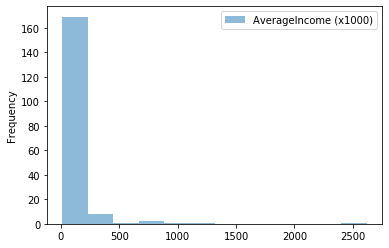

In [23]:
census_merged[['AverageIncome (x1000)']].plot.hist(bins=12, alpha=0.5)

We have some outlier that really squew the data, let's do some analysis

In [24]:
census_merged[['AverageIncome (x1000)']].median()

AverageIncome (x1000)    29.737121
dtype: float64

In [25]:
census_merged[['AverageIncome (x1000)']].describe()

,AverageIncome (x1000)
count,183.000000
mean,92.619496
std,242.871227
min,13.162769
25%,22.479439
50%,29.737121
75%,50.294744
max,2619.811086


To handle the data skew introduced by income inequality we divide the income in 7 quartile and we introduce a new column 'IncomeIndex' in the range [-3,3]

In [26]:
census_merged['IncomeIndex']=pd.qcut(census_merged['AverageIncome (x1000)'], 
                              q=     7,
                              labels=[-3, -2,   -1,  0,  1,  2,3])
census_merged[['AverageIncome (x1000)','IncomeIndex']].head()

,AverageIncome (x1000),IncomeIndex
0,120.887601,2
1,237.330318,3
2,216.394296,3
3,21.592036,-2
4,48.653144,2


We plot the IncomeIndex on the map

In [27]:
import folium
m = folium.Map(location=[nyc_centroid.y,nyc_centroid.x],zoom_start =10)
c=folium.Choropleth(
    geo_data='nyc_clean.geojson',
    data=census_merged,
     columns=['ZipCode', 'IncomeIndex'],
    key_on='feature.properties.ZipCode',
    fill_color='YlGn',
    name='choropleth',
    highlight=True,
).add_to(m)

m

#### Location Data (Foursquare)

During the course we have used the foursquare data manually implementing the request, for this project we are going to use the [libraries suggested by foursquare](https://developer.foursquare.com/docs/places-api/libraries/).

For Python the [suggested library](https://github.com/mLewisLogic/foursquare) can be installed using `pip` and in this notebook we assume that it's already installed in the python environment and available to the current running kernel

We load the credential from a file (that will not be committed on github)

In [28]:
credential=pd.read_json('foursquare_credential.json')

In [29]:
import foursquare
CLIENT_ID=credential.loc[0,'CLIENT_ID']
CLIENT_SECRET=credential.loc[0,'CLIENT_SECRET']
client = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)


Let's load the complete foursquare category tree

In [30]:
foursquare_categories=client.venues.categories()

The categories are returned in multilevel tree, that needs to be flattened to be used as a dataframe

In [31]:
fs_cat_tmp = []
def flat_categories(data,parent=[]):
    global max_category_level
    global fs_cat_tmp
    np = parent
    if 'name' in data:
        np = parent + [data['name']]
        fs_cat_tmp.append([data['name'],data['id']]+np)
    if 'categories' in data:
        for q in data['categories']:
            flat_categories(q,np)

In [32]:
import pandas as pd
import numpy as np
flat_categories(foursquare_categories)
fs_cat_df = pd.DataFrame(fs_cat_tmp,columns=['Name','Id','Level0','Level1','Level2','Level3','Level4'])
fs_cat_df.replace([None], np.nan, inplace=True)
fs_cat_df.head()

,Name,Id,Level0,Level1,Level2,Level3,Level4
0,Arts & Entertainment,4d4b7104d754a06370d81259,Arts & Entertainment,NaN,NaN,NaN,NaN
1,Amphitheater,56aa371be4b08b9a8d5734db,Arts & Entertainment,Amphitheater,NaN,NaN,NaN
2,Aquarium,4fceea171983d5d06c3e9823,Arts & Entertainment,Aquarium,NaN,NaN,NaN
3,Arcade,4bf58dd8d48988d1e1931735,Arts & Entertainment,Arcade,NaN,NaN,NaN
4,Art Gallery,4bf58dd8d48988d1e2931735,Arts & Entertainment,Art Gallery,NaN,NaN,NaN


Having all the categories in a dataframe gives us the possibility to choose at which granularity level we want to operate for the analisys of the various area.



### Methodology

In [33]:
census_merged

,ZipCode,Latitude,Longitude,Population,TotalIncome (x1000),AverageIncome (x1000),IncomeIndex
0,10162,40.769298,-73.949942,1726,208652.0,120.887601,2
1,10028,40.776865,-73.954721,44987,10676779.0,237.330318,3
2,10128,40.781656,-73.950281,59856,12952497.0,216.394296,3
3,10031,40.825857,-73.949451,60221,1300294.0,21.592036,-2
4,10009,40.726622,-73.978955,58595,2850831.0,48.653144,2
...,...,...,...,...,...,...,...
178,10464,40.867099,-73.797609,4634,198741.0,42.887570,1
179,11430,40.650916,-73.788526,229,8783.0,38.353712,1
180,10065,40.764539,-73.962753,29651,10550844.0,355.834339,3
181,10075,40.773149,-73.955329,25311,7347295.0,290.280708,3


Let's find the number of *Gym* for each zip code, to aggregate all the results we will search for a *mid-level* category: **Gym / Fitness Center**

In [59]:
category_id_gym=fs_cat_df[fs_cat_df['Name'].str.contains('Gym / Fitness Center')].iloc[0,1]
print("ID Category for Gym is: %s" %category_id_gym)

ID Category for Gym is: 4bf58dd8d48988d175941735


In [61]:
nyc_gym = pd.DataFrame(columns=['ZipCode','Name','Distance','VenueId'])
def retrive_gym(client,category_id_gym,zipCode,latitude,longitude,radius=500):
    ll = "%s,%s" %(latitude,longitude)
    result=[]
    #result=
    venues = client.venues.search(params={'categoryId': category_id_gym,'radius':radius, 'll': ll})
    if 'venues' in venues:
        for item in venues['venues']:
            result.append([zipCode,item['name'],item['location']['distance'],item['id']])
    return pd.DataFrame(result,columns=['ZipCode','Name','Distance','VenueId'])
for index, row  in census_merged.iterrows():
    zipcode= row[0]
    latitude = row[1]
    longitude = row[2]
    d=retrive_gym(client,category_id_gym,zipcode,latitude,longitude)
    nyc_gym=nyc_gym.append(d,ignore_index =True)
    

In [65]:
nyc_gym_dup = nyc_gym.copy()

In [84]:
nyc_gym_dup=pd.DataFrame(nyc_gym['ZipCode'].value_counts())
nyc_gym_dup.reset_index(inplace=True)
nyc_gym_dup.columns=['ZipCode','GymCount']
nyc_gym_dup.head()

,ZipCode,GymCount
0,10128,30
1,10012,30
2,10014,30
3,10016,30
4,10017,30


In [96]:
gym_count = census_merged[['ZipCode']].copy()
gym_count['GymCount']=0
gym_merged=nyc_gym_dup.merge(gym_count,how="right",on=['ZipCode'])[['ZipCode','GymCount_x']]
gym_merged.columns = ['ZipCode','GymCount']
gym_merged.fillna(0,inplace=True)
gym_merged['GymCount']=gym_merged['GymCount'].astype('int32')
gym_count=gym_merged.copy()

,ZipCode,GymCount
0,10128,30
1,10012,30
2,10014,30
3,10016,30
4,10017,30
...,...,...
178,11422,0
179,11693,0
180,11697,0
181,10464,0


In [110]:
census_merged = census_merged.merge(gym_count,how='left',on='ZipCode')
census_merged.head()

,ZipCode,Latitude,Longitude,Population,TotalIncome (x1000),AverageIncome (x1000),IncomeIndex,GymCount
0,10162,40.769298,-73.949942,1726,208652.0,120.887601,2,28
1,10028,40.776865,-73.954721,44987,10676779.0,237.330318,3,30
2,10128,40.781656,-73.950281,59856,12952497.0,216.394296,3,30
3,10031,40.825857,-73.949451,60221,1300294.0,21.592036,-2,12
4,10009,40.726622,-73.978955,58595,2850831.0,48.653144,2,29


In [115]:
import folium
m = folium.Map(location=[nyc_centroid.y,nyc_centroid.x],zoom_start =10)
c=folium.Choropleth(
    geo_data='nyc_clean.geojson',
    data=census_merged,
     columns=['ZipCode', 'GymCount'],
    key_on='feature.properties.ZipCode',
    fill_color='YlGn',
    name='choropleth',
    highlight=True,
).add_to(m)

m